# Analyzing Yale Dataset

In [85]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

(243, 320)


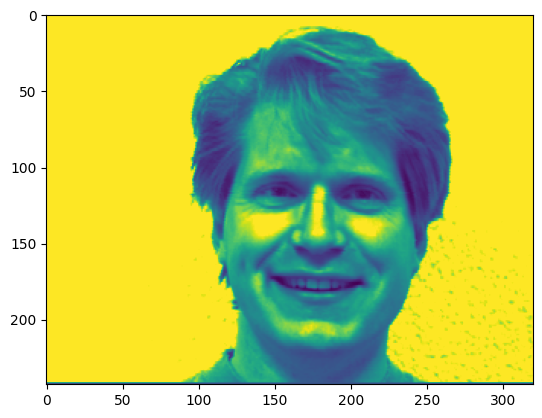

In [86]:
data_path = "./../data/yale/"
sample_file = data_path + "subject01.happy"
pixels = plt.imread(sample_file,)
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(pixels.shape)
plt.imshow(pixels)
plt.show()

In [87]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

In [88]:
def extract_from_file(f):
    img = Image.open(f)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    return cv2.cvtColor(pixels, cv2.COLOR_BGR2GRAY)

100%|██████████| 16/16 [00:00<00:00, 47.36it/s]


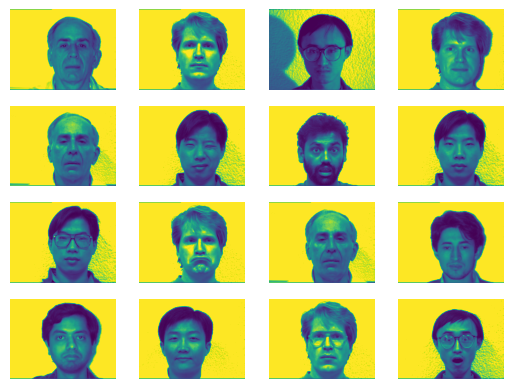

In [89]:
i = 1
DIRECTORY = './../data/yale/'
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    # path
    path = DIRECTORY + filename
    # get face
    face = extract_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.savefig("yale_faces.png")
plt.show()

In [90]:
files = pd.DataFrame(list_files(DIRECTORY, "subject"))

df = files[0].str.split(".", expand=True)
df['filenames'] = files
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df
df.head()

,subject,category,filenames
0,5,centerlight,subject05.centerlight
1,1,normal,subject01.normal
2,8,rightlight,subject08.rightlight
3,1,centerlight,subject01.centerlight
4,5,noglasses,subject05.noglasses


In [91]:
PER_CLASS = 7 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

y = df['subject']
X = df.drop('subject',axis=1)

X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=0, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

In [92]:
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filenames"]):
        path = DIRECTORY + filename
        # get face
        face = extract_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [93]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

100%|██████████| 105/105 [00:00<00:00, 1102.78it/s]

(60, 243, 320)
(105, 243, 320)


In [94]:
k = 75

X_train_col = X_train.reshape(X_train.shape[0], -1)
X_train_col = X_train_col.T
X_train_col.shape

(77760, 105)

In [95]:
X_mean = np.mean(X_train_col, axis=1)
X_mean = X_mean.reshape(-1,1)
X_mean.shape

(77760, 1)

In [96]:
X = X_train_col - X_mean

In [97]:
X_test_col = X_test.reshape(X_test.shape[0], -1)
X_test_col = X_test_col.T
X_test_centered = X_test_col - X_mean

In [98]:
L = X.T @ X
L.shape

(105, 105)

In [99]:
eigenval, eigenvec = np.linalg.eig(L)
sorted_index = np.argsort(eigenval)[::-1]
# Project the data onto the selected eigenvectors
eigenvec = eigenvec[:, sorted_index]
    # Return the projected data, the top-k eigenvalues and eigenvectors
W =eigenvec[:, :120]

In [100]:
V = X @ W

In [101]:
V.shape
for i in range(V.shape[1]):
    V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

In [102]:
k_s = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
rates = []
for i in range(len(k_s)):
    V_k = V[:, :k_s[i]]
    alpha_l = V_k.T  @ X
    alpha_p = V_k.T  @ X_test_centered
    recognized = 0
    for p in range(X_test_centered.shape[1]):
        dist = np.sum((alpha_l - alpha_p[:,p][:,np.newaxis])**2, axis=0)
        min_ind = np.argmin(dist)
        #print(y_test[p],y_train[min_ind], dist.shape)
        if y_test[p] == y_train[min_ind]:
            recognized += 1
    r = recognized/X_test_centered.shape[1]
    rates.append(r)

In [103]:
rates1 = []
for i in range(len(k_s)):
    V_k = V[:, 3:k_s[i]+3]
    alpha_l = V_k.T  @ X
    alpha_p = V_k.T  @ X_test_centered
    recognized = 0
    for p in range(X_test_centered.shape[1]):
        dist = np.sum((alpha_l - alpha_p[:,p][:,np.newaxis])**2, axis=0)
        min_ind = np.argmin(dist)
        #print(y_test[p],y_train[min_ind], dist.shape)
        if y_test[p] == y_train[min_ind]:
            recognized += 1
    r = recognized/X_test_centered.shape[1]
    rates1.append(r)

### Plotting recognition rates for different `k` values

Text(42.722222222222214, 0.5, 'Recognition Rate')

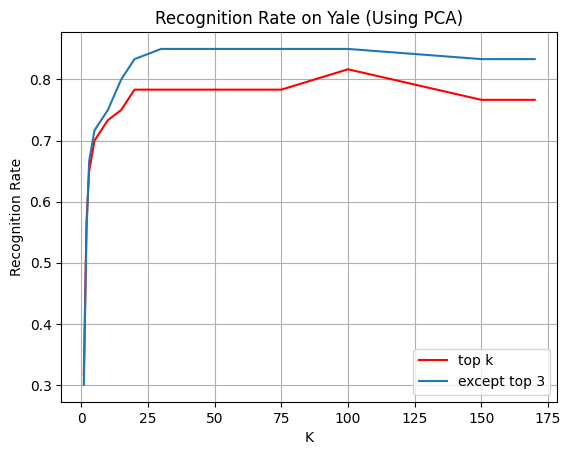

In [104]:
plt.plot(k_s, rates, c='red', label='top k')
plt.plot(k_s, rates1, label='except top 3')
plt.title("Recognition Rate on Yale (Using PCA)")
plt.xlabel("K")
plt.legend()
plt.grid()
plt.savefig("eigenfaces_yale.png")
plt.ylabel("Recognition Rate")